In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

In [44]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = data.shape[1]
    columns = data.columns
    df = pd.DataFrame(data)
    
    df_new = pd.DataFrame()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        for j in range(n_vars):
            df_new['var%d(t-%d)' % (j+1, i)] = df.shift(i)[columns[j]]
   
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        
        for j in range(n_vars):
            if i == 0:
                name = 'var%d(t)' % (j+1)
            else:
                name = 'var%d(t+%d)' % (j+1, i)
            df_new[name] = df.shift(-i)[columns[j]]
    
    if dropnan:
        df_new.dropna(inplace=True)
    return df_new

In [45]:
house_data = pd.read_excel("Clean_Data.xlsx")
house_data

,Date,Time,DateTime,System Setting,System Mode,Calendar Event,Program Mode,Cool Set Temp (C),Heat Set Temp (C),Current Temp (C),...,Thermostat Humidity (%RH),Thermostat Motion,Bedroom (C),Bedroom2,3rd floor landing (C),3rd floor landing2,3rd floor room (C),3rd floor room2,Basement (C),Basement2
0,2020-12-10,12:50:00,2020/12/10 12:50:00,heat,heatOff,auto,Home,21.0,21.0,21.3,...,30.0,1.0,21.6,0.0,20.9,0.0,21.0,0.0,22.8,0.0
1,2020-12-10,12:55:00,2020/12/10 12:55:00,heat,heatOff,auto,Home,21.0,21.0,21.1,...,32.0,1.0,21.6,0.0,20.9,0.0,20.9,0.0,22.7,1.0
2,2020-12-10,13:00:00,2020/12/10 13:00:00,heat,heatOff,auto,Home,21.0,21.0,20.9,...,32.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.7,1.0
3,2020-12-10,13:05:00,2020/12/10 13:05:00,heat,heatOff,auto,Home,21.0,21.0,20.7,...,33.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
4,2020-12-10,13:10:00,2020/12/10 13:10:00,heat,heatStage1On,auto,Home,21.0,21.0,20.6,...,33.0,1.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,2021-03-23,14:25:00,2021/3/23 14:25:00,heat,heatOff,NaN,Home,21.0,21.0,21.2,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.0,1.0
29672,2021-03-23,14:30:00,2021/3/23 14:30:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.1,0.0
29673,2021-03-23,14:35:00,2021/3/23 14:35:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0
29674,2021-03-23,14:40:00,2021/3/23 14:40:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0


In [4]:
enc = preprocessing.OneHotEncoder()
house_data = house_data.fillna(method = "bfill")
house_data.isnull().sum()

Date                              0
Time                              0
DateTime                          0
System Setting                    0
System Mode                       0
Calendar Event                29548
Program Mode                      0
Cool Set Temp (C)                 0
Heat Set Temp (C)                 0
Current Temp (C)                  0
Current Humidity (%RH)            0
Outdoor Temp (C)                  0
Wind Speed (km/h)                 0
Cool Stage 1 (sec)                0
Heat Stage 1 (sec)                0
Fan (sec)                         0
Thermostat Temperature (C)        0
Thermostat Humidity (%RH)         0
Thermostat Motion                 0
Bedroom (C)                       0
Bedroom2                          0
3rd floor landing (C)             0
3rd floor landing2                0
3rd floor room (C)                0
3rd floor room2                   0
Basement (C)                      0
Basement2                         0
dtype: int64

In [5]:
numerical_vars = ['Heat Set Temp (C)', 'Current Temp (C)', 'Current Humidity (%RH)', 'Outdoor Temp (C)','Thermostat Temperature (C)', 'Thermostat Humidity (%RH)']
sc = StandardScaler()
sc.fit(house_data[numerical_vars])
scalar_data = sc.transform(house_data[numerical_vars])

In [6]:
y_auxHeat = house_data['Heat Stage 1 (sec)'].to_numpy()
#oe = OrdinalEncoder()
#y_auxHeat = oe.fit_transform(y_auxHeat.reshape(-1, 1))
sc = StandardScaler()
sc.fit(y_auxHeat.reshape(-1,1))
y_auxHeat = sc.transform(y_auxHeat.reshape(-1,1))

In [7]:
scaler_house_data = house_data[numerical_vars].copy()
scaler_house_data[numerical_vars] = scalar_data
scaler_house_data["Heat Stage 1"] = y_auxHeat

In [8]:
reframed = series_to_supervised(scaler_house_data, 12, 1)
reframed

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var1(t-11),var2(t-11),var3(t-11),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
12,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,-0.837756,0.0,1.489502,1.930176,...,0.346315,2.183776,-0.837756,0.0,-0.225278,2.183776,1.462204,-0.225278,2.183776,-0.837756
13,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,-0.837756,0.0,0.346315,1.930176,...,-0.225278,2.183776,-0.837756,0.0,-0.225278,2.183776,1.462204,-0.225278,2.183776,-0.837756
14,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,-0.837756,0.0,-0.796872,2.183776,...,-0.225278,2.183776,-0.837756,0.0,-0.796872,2.183776,1.443502,-0.796872,2.183776,1.124176
15,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,0.200914,0.0,-1.368465,2.183776,...,-0.796872,2.183776,1.124176,0.0,-0.796872,2.183776,1.443502,-0.796872,2.183776,1.470399
16,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,1.470399,0.0,-0.796872,2.183776,...,-0.796872,2.183776,1.470399,0.0,0.346315,2.183776,1.443502,0.346315,2.183776,-0.145310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.145447,3.204282,-0.098625,-0.837756,0.0,3.204282,-0.098625,...,2.061095,-0.859425,-0.837756,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,-0.837756
29672,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,-0.837756,0.0,3.204282,-0.098625,...,2.061095,-0.859425,-0.837756,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,-0.837756
29673,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,-0.837756,0.0,3.204282,-0.098625,...,1.489502,-0.859425,-0.837756,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,-0.837756
29674,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,-0.837756,0.0,3.204282,-0.098625,...,1.489502,-0.859425,-0.837756,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,-0.837756


In [46]:
weather_data = pd.read_excel("WeatherData.xlsx")
weather_data

,Unnamed: 0,Air Temp,Atmos_Pres,Wetness,Rel_Humidity,Solar_Rad,Wind_Dir,Wind_Speed
0,2020-12-10 12:50:00,4.376,991.65,8.24,78.8,48.1,303.2,0.00
1,2020-12-10 12:55:00,4.272,991.75,8.82,78.9,60.6,304.7,0.00
2,2020-12-10 13:00:00,4.298,991.55,8.82,79.4,108.1,308.9,0.00
3,2020-12-10 13:05:00,4.428,991.75,8.82,79.0,115.6,311.7,0.00
4,2020-12-10 13:10:00,4.454,991.95,8.82,79.2,119.4,263.9,0.00
...,...,...,...,...,...,...,...,...
29677,2021-03-23 14:25:00,16.725,992.15,0.00,26.0,471.9,168.5,2.52
29678,2021-03-23 14:30:00,17.011,992.25,0.00,25.3,425.6,174.1,2.52
29679,2021-03-23 14:35:00,16.725,992.15,0.00,25.4,506.9,148.8,3.02
29680,2021-03-23 14:40:00,16.796,992.15,0.00,25.4,360.6,161.5,2.01


In [50]:
house_data.DateTime = pd.to_datetime(house_data.DateTime)

In [51]:
house_data.set_index('DateTime',inplace = True)

In [42]:
house_data.index[0]

'2020/12/10 12:50:00'

In [62]:
dfM=house_data.resample('H').mean()

In [63]:
dfM

,Cool Set Temp (C),Heat Set Temp (C),Current Temp (C),Current Humidity (%RH),Outdoor Temp (C),Wind Speed (km/h),Cool Stage 1 (sec),Heat Stage 1 (sec),Fan (sec),Thermostat Temperature (C),Thermostat Humidity (%RH),Thermostat Motion,Bedroom (C),Bedroom2,3rd floor landing (C),3rd floor landing2,3rd floor room (C),3rd floor room2,Basement (C),Basement2
DateTime,,,,,,,,,,,,,,,,,,,,
2020-12-10 12:00:00,21.0,21.0,21.200000,31.000000,5.00,0.0,0.0,0.00,0.00,21.200000,31.000000,1.000000,21.600000,0.00,20.900000,0.000000,20.950000,0.0,22.750000,0.500000
2020-12-10 13:00:00,21.0,21.0,20.866667,32.916667,5.30,0.0,0.0,90.00,93.75,20.866667,32.916667,0.416667,21.850000,0.00,20.958333,0.416667,21.033333,0.0,22.758333,0.083333
2020-12-10 14:00:00,21.0,21.0,20.875000,33.000000,5.30,0.0,0.0,115.00,122.50,20.875000,33.000000,0.666667,21.808333,0.00,20.958333,0.000000,20.983333,0.0,22.733333,0.416667
2020-12-10 15:00:00,21.0,21.0,20.841667,33.000000,5.30,0.0,0.0,85.00,88.75,20.841667,33.000000,0.416667,21.816667,0.00,21.008333,0.500000,21.000000,0.0,22.783333,0.250000
2020-12-10 16:00:00,21.0,21.0,20.883333,33.083333,4.15,0.0,0.0,93.75,100.00,20.883333,33.083333,1.000000,21.808333,0.25,20.983333,0.000000,20.966667,0.0,22.833333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-23 10:00:00,21.0,21.0,21.000000,22.333333,9.45,0.0,0.0,0.00,0.00,21.000000,22.333333,0.250000,21.800000,0.00,21.450000,0.166667,21.000000,0.0,22.091667,0.250000
2021-03-23 11:00:00,21.0,21.0,21.033333,22.000000,11.65,0.0,0.0,0.00,0.00,21.033333,22.000000,0.750000,21.800000,0.00,21.558333,0.000000,21.000000,0.0,22.025000,0.500000
2021-03-23 12:00:00,21.0,21.0,21.308333,23.166667,13.35,0.0,0.0,0.00,0.00,21.308333,23.166667,0.916667,21.800000,0.00,21.600000,0.000000,21.058333,0.0,22.116667,0.000000


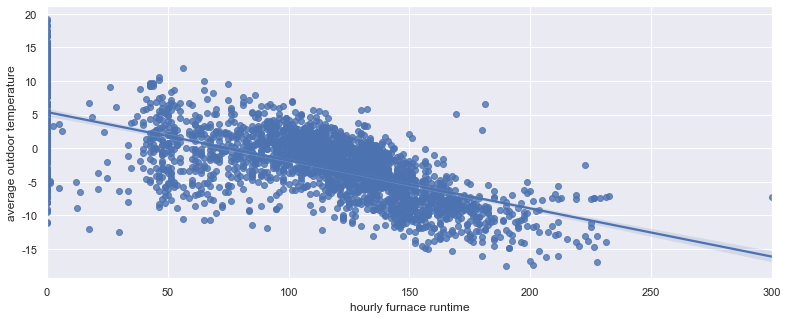

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)


sns.regplot(y="Outdoor Temp (C)", x="Heat Stage 1 (sec)", data=dfM)
plt.xlabel('hourly furnace runtime')
plt.ylabel('average outdoor temperature')
plt.savefig('25.jpg')
plt.show()

In [56]:
help(sns.regplot)

Help on function regplot in module seaborn.regression:

regplot(*, x=None, y=None, data=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, label=None, color=None, marker='o', scatter_kws=None, line_kws=None, ax=None)
    Plot data and a linear regression model fit.
    
    There are a number of mutually exclusive options for estimating the
    regression model. See the :ref:`tutorial <regression_tutorial>` for more
    information.    
    
    Parameters
    ----------
    x, y: string, series, or vector array
        Input variables. If strings, these should correspond with column names
        in ``data``. When pandas objects are used, axes will be labeled with
        the series name.
    data : DataFrame
        Tidy ("long-form") dataframe where each column is

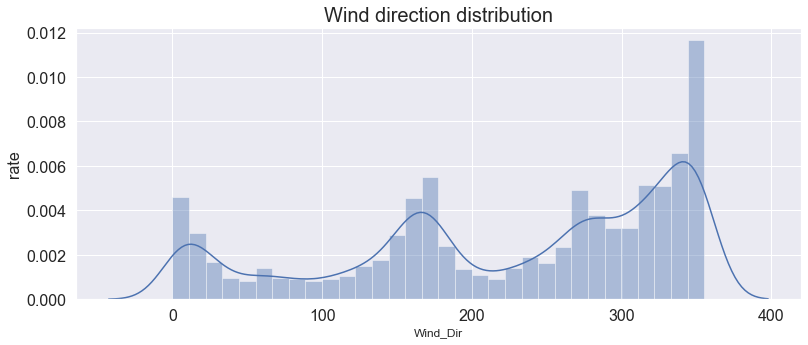

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()                                   
np.random.seed(0)                           

from matplotlib.font_manager import FontProperties   
myfont=FontProperties(size=14)
sns.set(font=myfont.get_name())
plt.rcParams['axes.unicode_minus']=False      

x = weather_data['Wind_Dir']

plt.rcParams['figure.figsize'] = (13, 5)    
f = plt.figure()                            


sns.distplot(x)                           
plt.ylabel("rate", fontsize=16)
plt.xticks(fontsize=16)                  
plt.yticks(fontsize=16)
plt.title("Wind direction distribution", fontsize=20)            
plt.savefig('wind_dir.jpg')
plt.show()

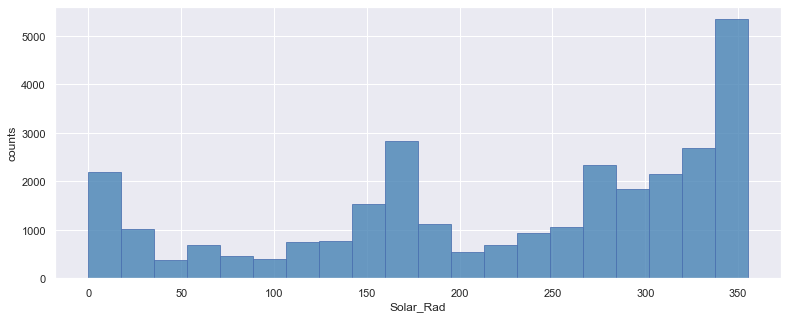

In [11]:
plt.xlabel('Solar_Rad')
plt.ylabel('counts')
plt.hist(x, bins=20, alpha=0.8, histtype='barstacked',color='steelblue', edgecolor='b')
plt.savefig('solar.jpg')

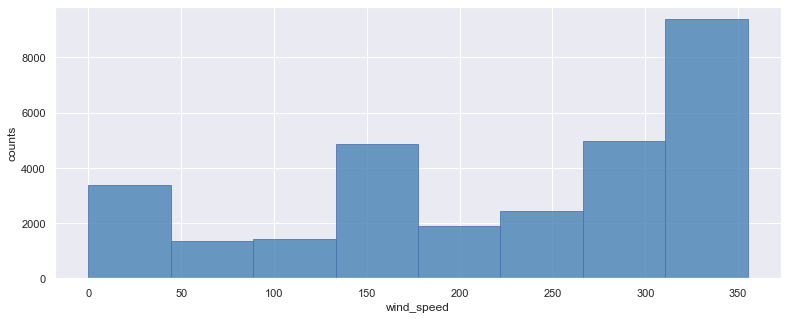

In [12]:
plt.xlabel('wind_speed')
plt.ylabel('counts')
plt.hist(x, bins=8, alpha=0.8, histtype='barstacked',color='steelblue', edgecolor='b')
plt.savefig('wind_speed.jpg')

In [13]:
pip install constants

You should consider upgrading via the '/Users/chenyeming/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
sc = StandardScaler()
sc.fit(weather_data[["Air Temp","Atmos_Pres","Wetness","Rel_Humidity","Solar_Rad","Wind_Dir","Wind_Speed"]])
weather_scalar_data = sc.transform(weather_data[["Air Temp","Atmos_Pres","Wetness","Rel_Humidity","Solar_Rad","Wind_Dir","Wind_Speed"]])
weather_scalar_data = pd.DataFrame(weather_scalar_data)
weather_scalar_data.columns = ["Air Temp","Atmos_Pres","Wetness","Rel_Humidity","Solar_Rad","Wind_Dir","Wind_Speed"]
weather_scalar_data

,Air Temp,Atmos_Pres,Wetness,Rel_Humidity,Solar_Rad,Wind_Dir,Wind_Speed
0,1.201504,0.099141,-0.872215,0.056498,-0.249896,0.713867,-0.857137
1,1.183855,0.110594,-0.859391,0.062935,-0.175408,0.727331,-0.857137
2,1.188268,0.087688,-0.859391,0.095121,0.107644,0.765030,-0.857137
3,1.210329,0.110594,-0.859391,0.069372,0.152337,0.790163,-0.857137
4,1.214741,0.133501,-0.859391,0.082247,0.174981,0.361112,-0.857137
...,...,...,...,...,...,...,...
29677,3.297132,0.156407,-1.054407,-3.342304,2.275528,-0.495196,1.452381
29678,3.345667,0.167860,-1.054407,-3.387364,1.999626,-0.444930,1.452381
29679,3.297132,0.156407,-1.054407,-3.380927,2.484093,-0.672022,1.910618
29680,3.309181,0.156407,-1.054407,-3.380927,1.612291,-0.558028,0.984978


In [15]:
weather_scalar_data1 = weather_scalar_data['Solar_Rad']
weather_scalar_data2 = weather_scalar_data[['Wind_Dir','Wind_Speed']]

In [16]:
new_data= pd.concat([reframed, weather_scalar_data1], axis=1)

new_data.dropna(axis = 0,how="any",inplace = True)

In [17]:
new_data2= pd.concat([reframed, weather_scalar_data2], axis=1)

new_data2.dropna(axis = 0,how="any",inplace = True)

In [18]:
X = new_data.drop(labels = ['var7(t)'], axis = 1)


In [19]:
X2 = new_data2.drop(labels = ['var7(t)'], axis = 1)

In [20]:
y_auxHeat = new_data['var7(t)']
#y_auxHeat = to_categorical(y_auxHeat)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(np.array(y_auxHeat).reshape(-1,1))
y_auxHeat = sc.transform(np.array(y_auxHeat).reshape(-1,1))

X_train = X.iloc[:23736,]
y_train = y_auxHeat[:23736,]
X_test = X.iloc[23736:]
y_test = y_auxHeat[23736:]

In [21]:
from sklearn.metrics import r2_score
from sklearn import linear_model    
model = linear_model.LinearRegression()

model.fit(X,y_auxHeat)
predict_y = model.predict(X)

r2_score(predict_y,y_auxHeat)

0.6263708858908118

In [23]:
y_auxHeat2 = new_data2['var7(t)']
#y_auxHeat = to_categorical(y_auxHeat)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(np.array(y_auxHeat2).reshape(-1,1))
y_auxHeat2 = sc.transform(np.array(y_auxHeat2).reshape(-1,1))

X_train2 = X2.iloc[:23736,]
y_train2 = y_auxHeat2[:23736,]
X_test2 = X2.iloc[23736:]
y_test2 = y_auxHeat2[23736:]

In [24]:
from sklearn.metrics import r2_score
from sklearn import linear_model    
model = linear_model.LinearRegression()

model.fit(X2,y_auxHeat2)
predict_y2 = model.predict(X2)

r2_score(predict_y2,y_auxHeat2)

0.6209197767758465

In [26]:
X_train.shape

(23736, 91)

In [27]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 91))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mse']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 50, shuffle = True)

Epoch 1/50
371/371 [==============================] - 0s 921us/step - loss: 0.3818 - mse: 0.3497 - val_loss: 0.2385 - val_mse: 0.1576
Epoch 2/50
371/371 [==============================] - 0s 677us/step - loss: 0.1821 - mse: 0.1447 - val_loss: 0.1656 - val_mse: 0.0951
Epoch 3/50
371/371 [==============================] - 0s 638us/step - loss: 0.1486 - mse: 0.0857 - val_loss: 0.1329 - val_mse: 0.0801
Epoch 4/50
371/371 [==============================] - 0s 649us/step - loss: 0.1370 - mse: 0.0758 - val_loss: 0.1168 - val_mse: 0.0789
Epoch 5/50
371/371 [==============================] - 0s 739us/step - loss: 0.1306 - mse: 0.0725 - val_loss: 0.1108 - val_mse: 0.0729
Epoch 6/50
371/371 [==============================] - 0s 669us/step - loss: 0.1269 - mse: 0.0704 - val_loss: 0.1070 - val_mse: 0.0710
Epoch 7/50
371/371 [==============================] - 0s 699us/step - loss: 0.1243 - mse: 0.0696 - val_loss: 0.1064 - val_mse: 0.0740
Epoch 8/50
371/371 [==============================] - 0s 704us

In [35]:
classifier2 = Sequential()

# Adding the input layer and the first hidden layer
classifier2.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 92))

# Adding the second hidden layer
classifier2.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier2.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))

# Compiling the ANN
classifier2.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mse']) 

# Fitting the ANN to the Training set
history2 = classifier2.fit(X_train2, y_train2, validation_data = (X_test2, y_test2), batch_size = 64, epochs = 50, shuffle = True)

Epoch 1/50
371/371 [==============================] - 0s 878us/step - loss: 0.3704 - mse: 0.3437 - val_loss: 0.2435 - val_mse: 0.1470
Epoch 2/50
371/371 [==============================] - 0s 640us/step - loss: 0.1897 - mse: 0.1734 - val_loss: 0.1707 - val_mse: 0.0976
Epoch 3/50
371/371 [==============================] - 0s 684us/step - loss: 0.1573 - mse: 0.1005 - val_loss: 0.1280 - val_mse: 0.0780
Epoch 4/50
371/371 [==============================] - 0s 655us/step - loss: 0.1423 - mse: 0.0807 - val_loss: 0.1274 - val_mse: 0.0794
Epoch 5/50
371/371 [==============================] - 0s 699us/step - loss: 0.1353 - mse: 0.0778 - val_loss: 0.1164 - val_mse: 0.0751
Epoch 6/50
371/371 [==============================] - 0s 681us/step - loss: 0.1301 - mse: 0.0747 - val_loss: 0.1112 - val_mse: 0.0735
Epoch 7/50
371/371 [==============================] - 0s 668us/step - loss: 0.1282 - mse: 0.0728 - val_loss: 0.1108 - val_mse: 0.0749
Epoch 8/50
371/371 [==============================] - 0s 632us

In [28]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                2208      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 2,833
Trainable params: 2,833
Non-trainable params: 0
_________________________________________________________________


In [36]:
min(history.history['loss']),min(history.history['val_loss']),min(history.history['mse']),min(history.history['val_mse'])

(0.10402262955904007,
 0.0908203199505806,
 0.05760237202048302,
 0.05910220742225647)

In [39]:
min(history2.history['loss']),min(history2.history['val_loss']),min(history2.history['mse']),min(history2.history['val_mse'])

(0.10759392380714417,
 0.0930587500333786,
 0.059845566749572754,
 0.05965525656938553)

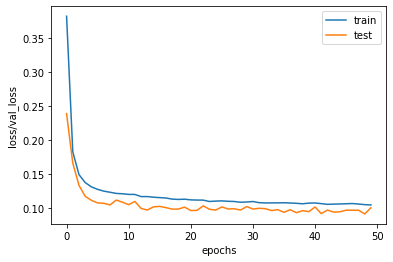

In [29]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss/val_loss")
plt.savefig("Weather1.png")
plt.show()

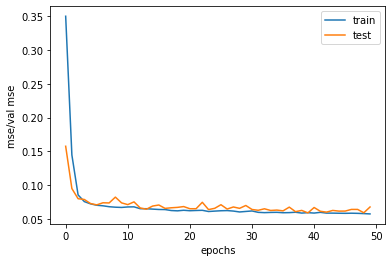

In [30]:
plt.plot(history.history['mse'], label = 'train')
plt.plot(history.history['val_mse'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("mse/val mse")
plt.savefig("Weather2.png")
plt.show()

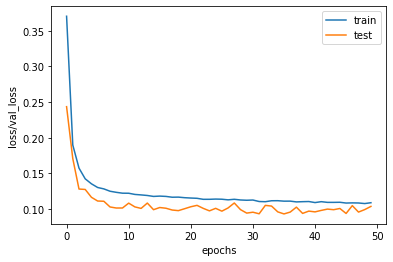

In [37]:
plt.plot(history2.history['loss'], label = 'train')
plt.plot(history2.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss/val_loss")
plt.savefig("Weather3.png")
plt.show()

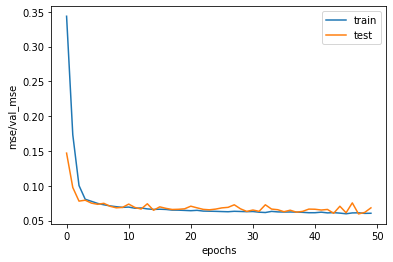

In [38]:
plt.plot(history2.history['mse'], label = 'train')
plt.plot(history2.history['val_mse'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("mse/val_mse")
plt.savefig("Weather4.png")
plt.show()

In [ ]:
y_predicted = classifier.predict(X_test)

In [ ]:
y_predicted = np.argmax(y_predicted, axis = 1)
y_predicted

In [ ]:
y_test = np.argmax(y_test, axis = 1)

In [ ]:
test_sum = y_test.sum()*15
test_sum

In [ ]:
predicted_sum = y_predicted.sum()*15

In [ ]:
predicted_sum

In [ ]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

In [ ]:
from sklearn.metrics import mean_absolute_error,f1_score,accuracy_score

In [ ]:
y_train_predicted = classifier.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis = 1)
y_train = np.argmax(y_train, axis = 1)

In [ ]:
f1_score(y_train, y_train_predicted, average = 'weighted')

In [ ]:
accuracy_score(y_train, y_train_predicted)

In [ ]:
mean_absolute_error(y_train, y_train_predicted)

In [ ]:
mean_absolute_error(y_test, y_predicted)

In [ ]:
accuracy_score(y_test, y_predicted)

In [ ]:
f1_score(y_test, y_predicted, average = 'weighted')